# Mean Variance Optimization

## Utility function
the Utility function is defined as

$U(h) = h^T\cdot \alpha -\lambda (h^T\cdot \Omega \cdot h) - \gamma (k_0 + k_1 |h - h_0|^{0.5}) |h - h_0| $

subject to:
- $ A_{eq} \cdot h = b_{eq} $
- $ A_{ie} \cdot h \le b_{ie} $

Where
- Expected return = $ h^T\cdot \alpha $
- Expected Risk = $ h^T\cdot \Omega \cdot h $
- Risk Aversion $ \lambda $
- Trading Cost Penalty $ (k_0 + k_1 |h - h_0|^{0.5}) |h - h_0| $, Using Loeb's model
- Transaction cost amortization factor $ \gamma $


Optimal weights 
$h_{opt} = arg\max_{h} U(h)$

## Analytical Solution

Analystcal solution is possible without transaction cost and without inequality constraint

$\nabla_h ( U(h) +\theta 1^T_k \cdot (A_{eq} \cdot h - b_{eq}) ) = 0 $

$\theta \ge 0$

$\implies \alpha - 2\lambda \Omega \cdot h +\theta A_{eq}^T \cdot 1_k= 0$

$\implies h_{opt} = \frac{1}{2\lambda} \Omega^{-1} (\alpha + \theta A_{eq}^T \cdot 1_k ) $ and $ A_{eq} \cdot h_{opt} = b_{eq} $

eliminate $\theta$ to get analytical solution for $h_{opt}$

## Computation Solution

There are two options

- Use Scipy
- Use CVXopt




In [1]:
# from portopt import QPPortOpt
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
import scipy.optimize as opt
import numpy as np
import logging


class PortOpt:
    def __init__(self, alp, cov, risk_aversion, h_init, tc_param):
        self._alpha         = alp
        self._V             = cov
        self._risk_aversion = risk_aversion
        self._n_asset       = self._alpha.shape[1]        
        self._tc_param      = tc_param
        self._constraints   = []
        self._debug         = False
        self._asset_bounds  = {'min':[-np.inf for _ in range(self._n_asset)],
                               'max':[np.inf for _ in range(self._n_asset)]}
        self._message       = "Not Set"
        self._success       = False
        self._logger        = logging.getLogger('PortOpt')
        if h_init is not None:
            self._h_init = h_init
   
    def addConstraint(self, A, b, constraint_type='eq'):
        self._constraints.append({'type':constraint_type, 'A':A, 'b':b})
        
    def setBounds(self, h_bnd, bnd_type='min'):
        self._asset_bounds[bnd_type]= h_bnd
        
    def setDebugMode(self):
        """Check inputs are OK"""
        self._debug = True
        self._logger.setLevel(logging.DEBUG)
        

class QPPortOpt(PortOpt):
    """Mean Variance Optimization"""

    
    def __init__(self, alp, cov, risk_aversion=1, h_init=None, tc_param=None):
        self._method = 'SLSQP'
        super().__init__(alp, cov, risk_aversion, h_init, tc_param)
        

    
    def _utility(self, h):
        _h        = h.reshape(1,-1)
        _mean     = np.dot(self._alpha, np.transpose(_h))
        _variance = np.dot(np.dot(_h, self._V), np.transpose(_h))
        _dh       = abs(_h - self._h_init)
        if self._tc_param is not None:
            _tcost    = self._tc_param['tcaf']*np.dot( (self._tc_param['k0'] + self._tc_param['k1'] * np.power(_dh, 0.5)), np.transpose(_dh))
        else:
            _tcost    = 0
        _util     = _mean.item() - self._risk_aversion * _variance.item() - _tcost.item()
        return -1 * _util

    def optimize(self):
        _constr = [{'type': c['type'],
                    'fun': lambda h: (c['b'] - np.dot(c['A'], 
                                    np.transpose(h.reshape(1,-1)))).item()} for c in self._constraints]
        _bnds   = opt.Bounds(self._asset_bounds['min'], self._asset_bounds['max'])

        _out = opt.minimize(self._utility, self._h_init, 
                           method      = self._method,
                           bounds      = _bnds,
                           constraints = _constr,
                           options     = {'ftol': 1e-12, 'disp': self._debug})
        self._message = _out.message
        self._success = _out.success
        if (self._success):
            self._h_opt = _out.x
        else:
            self._h_opt = h_init
            self._logger.error(self._message)
        return self._h_opt
    
    def getRiskRet(self):
        _h        = self._h_opt.reshape(1,-1)
        _mean     = np.dot(self._alpha, np.transpose(_h))
        _variance = np.dot(np.dot(_h, self._V), np.transpose(_h))
        return (_mean[0][0], np.sqrt(_variance).item())
            

In [2]:
alp = np.array([[1.1, 3.2, 2.1, 3.2]])
cov = np.matrix([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
h0  = np.array([0.25, 0.25, 0.25, 0.25])
risk_aversion = 0.001
tc = dict()
tc['tcaf'] = 0.00001
tc['k0']   = 0.05
tc['k1']   = np.array([[0.1, 0.1, 0.1, 0.1]])
mvo   = QPPortOpt(alp, cov, risk_aversion, h0, tc)


# add a sum to 100% constraint
Aeq = np.array([[1.0, 1.0, 1.0, 1.0]])
beq = np.array([[1.0]])
mvo.addConstraint(Aeq, beq, constraint_type='eq')


# add no shorting constraint
h_min = [0.0, 0.0, 0.0, 0.0]
mvo.setBounds(h_min, bnd_type='min')
h_opt =  mvo.optimize()

In [3]:
mvo._message

'Optimization terminated successfully.'

In [4]:
h_opt

array([9.71445147e-16, 5.00000000e-01, 0.00000000e+00, 5.00000000e-01])

In [5]:
h_opt.sum(0)

1.0000000000000004

In [6]:
mvo.getRiskRet()

(3.1999999999999993, 0.707106781186547)

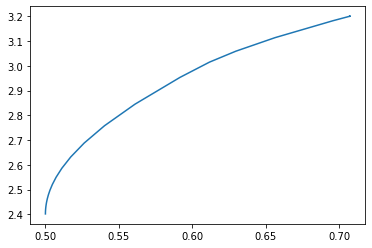

In [8]:
sig =[]
er = []
for risk_aversion in np.logspace(np.log(0.5), np.log(20), num=40):
    mvo._risk_aversion = risk_aversion
    h_opt =  mvo.optimize()
    ret, risk = mvo.getRiskRet()
    sig.append(risk)
    er.append(ret)
import matplotlib.pyplot as plt
plt.plot(sig, er)
plt.show();

## Mutual Fund separation theorem

Any portfolio on the efficient frontier is composed of two funds
- The minimum variance portfolio
- Any other portfolio on the efficient frontier

the Minimum variance portfolio:

$ h_0 = \frac{\Omega^{-1}\mathbf{1}}{\mathbf{1}^T\Omega^{-1}\mathbf{1}} $

the efficient portfolio:

$ h = \frac{\Omega^{-1}\alpha}{\mathbf{1}^T\Omega^{-1}\alpha} $

any portfolio

$ h_{opt} = \theta h_0 + (1-\theta) h $

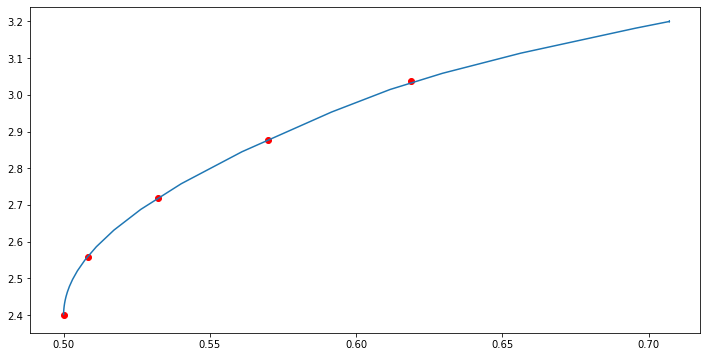

In [9]:
h0 = np.array([0.25, 0.25, 0.25, 0.25])
h = alp/alp.sum()

sig2 =[]
er2 = []
for theta in np.linspace(-1, 1, num = 5):
    h_opt = theta * h0 + (1- theta) * h
    h_opt = h_opt.reshape(1,-1)
    er2.append(np.dot(alp, np.transpose(h_opt)))
    vari = np.dot(np.dot(h_opt, cov), np.transpose(h_opt))
    sig2.append(np.sqrt(vari.item()))

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(sig, er)
ax.scatter(sig2, er2, c='red')

plt.show()
    
    

In [103]:
from cvxpy import Variable, Problem, Maximize, norm, SCS, Parameter, sqrt , multiply
from cvxpy.atoms import quad_form
class CVXPortOpt(PortOpt):
    def __init__(self, alp, cov, risk_aversion, h_init, tc_param):
        super().__init__(alp, cov, risk_aversion, h_init, tc_param)       
        self._h_opt = Variable((1,self._n_asset))
        
    def optimize(self):
        _constr = []
        for c in self._constraints:
            if c['type'] == 'eq':
                _constr.append(c['A']*self._h_opt.T == c['b'])
            elif c['type'] == 'ineq':
                _constr.append(c['A']*self._h_opt.T <= c['b'])
        if self._asset_bounds is not None:
            if 'max' in self._asset_bounds.keys():
                _constr.append(self._h_opt <= np.array(self._asset_bounds['max']).reshape(1,-1))
            if 'min' in self._asset_bounds.keys():
                _constr.append(np.array(self._asset_bounds['min']).reshape(1,-1) <= self._h_opt)            
                
        _ret = self._h_opt * self._alpha.T
        _risk = quad_form(self._h_opt.T, self._V)
#         _tc = None
#         if (self._tc_param is not None) and (self._h_init is not None):
#             if (self._tc_param['tcaf'] != 0):
#                 _dh = self._h_opt - self._h_init.reshape(1,-1)
#                 _tc   = self._tc_param['tcaf'] * (self._tc_param['k0'] + multiply(self._tc_param['k1'],sqrt(_dh) )) * _dh.T
#         if (_tc is None) and ('ineq' not in self.__constraints.keys()) and (self._asset_bounds is None):
#             return  AnalPortOpt(self._alpha, self._V, self._risk_aversion, None, None, self._constraints['A'], self._constraints['b']).optimize()                
#         else:
        print(_constr)
        _prob = Problem(Maximize(_ret - self._risk_aversion * _risk ), _constr)
        print(_prob)
#         try:
        _prob.solve(qcp=True, solver=SCS)
        return self._h_opt
#         except Exception as err:
#             print(err)
#             if self._debug:
#                 print(e)
#             _p = QPPortOpt(alp, cov, risk_aversion, self._h_init, tc_param)
#             for c in self._constraints:
#                 if c['type'] == 'eq':
#                     for row in range(c['A'].shape[0]):
#                         _p.addConstraint({'type':'eq', 'A':c['A'][row], 'b':c['b'][row]})
#                 elif c['type'] == 'ineq':
#                     for row in range(c['A'].shape[0]):
#                         _p.addConstraint({'type':'ineq', 'A':c['A'][row], 'b':c['b'][row]})
#             _p.setBounds()
#             return _p.optimize()


In [104]:

mvo   = CVXPortOpt(alp, cov, risk_aversion, h0, None)


# add a sum to 100% constraint
Aeq = np.array([[1.0, 1.0, 1.0, 1.0]])
beq = np.array([[1.0]])
mvo.addConstraint(Aeq, beq, constraint_type='eq')


# add no shorting constraint
h_min = [0.0, 0.0, 0.0, 0.0]
mvo.setBounds(h_min, bnd_type='min')
h_opt =  mvo.optimize()

[Equality(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, NONNEGATIVE, (1, 1))), Inequality(Variable((1, 4))), Inequality(Constant(CONSTANT, ZERO, (1, 4)))]
maximize var966 * [[1.1]
 [3.2]
 [2.1]
 [3.2]] + -990.2213219677761 * QuadForm(var966.T, [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]])
subject to [[1. 1. 1. 1.]] * var966.T == [[1.]]
           var966 <= [[inf inf inf inf]]
           [[0. 0. 0. 0.]] <= var966


In [100]:
h_opt.value